# Welcome to the coolpuppy walkthrough notebook!

Please see https://github.com/open2c/open2c_examples for detailed explanation of how snipping and pileups work, and explanation of some terminology

In [1]:
# If you are a developer, you may want to reload the packages on a fly. 
# Jupyter has a magic for this particular purpose:
%load_ext autoreload
%autoreload 2

In [2]:
# import standard python libraries
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 96
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
# import libraries for biological data analysis
from coolpuppy import coolpup
from plotpuppy import plotpup
import cooler
import bioframe
import cooltools
from cooltools import expected_cis
from cooltools.lib import plotting

## Download data

For the test, we collected the data from [immortalized human foreskin fibroblast cell line HFFc6](https://data.4dnucleome.org/ontology-terms/EFO:0009318/):
- Micro-C data from [Krietenstein et al. 2020](https://pubmed.ncbi.nlm.nih.gov/32213324/)
- ChIP-Seq for CTCF from [ENCODE ENCSR000DWQ](https://www.encodeproject.org/experiments/ENCSR000DWQ/)

You can automatically download test datasets with cooltools. More information on the files and how they were obtained is available from the datasets description. 


In [4]:
# Print available datasets for download
cooltools.print_available_datasets()

1) HFF_MicroC : Micro-C data from HFF human cells for two chromosomes (hg38) in a multi-resolution mcool format. 
	Downloaded from https://osf.io/3h9js/download 
	Stored as test.mcool 
	Original md5sum: e4a0fc25c8dc3d38e9065fd74c565dd1

2) HFF_CTCF_fc : ChIP-Seq fold change over input with CTCF antibodies in HFF cells (hg38). Downloaded from ENCODE ENCSR000DWQ, ENCFF761RHS.bigWig file 
	Downloaded from https://osf.io/w92u3/download 
	Stored as test_CTCF.bigWig 
	Original md5sum: 62429de974b5b4a379578cc85adc65a3

3) HFF_CTCF_binding : Binding sites called from CTCF ChIP-Seq peaks for HFF cells (hg38). Peaks are from ENCODE ENCSR000DWQ, ENCFF498QCT.bed file. The motifs are called with gimmemotifs (options --nreport 1 --cutoff 0), with JASPAR pwm MA0139. 
	Downloaded from https://osf.io/c9pwe/download 
	Stored as test_CTCF.bed.gz 
	Original md5sum: 61ecfdfa821571a8e0ea362e8fd48f63



In [5]:
# Downloading test data for pileups
# cache = True will doanload the data only if it was not previously downloaded
# data_dir="./" will force download to the current directory
cool_file = cooltools.download_data("HFF_MicroC", cache=True, data_dir='./')
ctcf_peaks_file = cooltools.download_data("HFF_CTCF_binding", cache=True, data_dir='./')
ctcf_fc_file = cooltools.download_data("HFF_CTCF_fc", cache=True, data_dir='./')

In [6]:
# Open cool file with Micro-C data:
clr = cooler.Cooler(f'{cool_file}::/resolutions/10000')
# Set up selected data resolution:
resolution = 10000

In [7]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.make_chromarms(hg38_chromsizes, hg38_cens)

# Select only chromosomes that are present in the cooler. 
# This step is typically not required! we call it only because the test data are reduced. 
hg38_arms = hg38_arms.set_index("chrom").loc[clr.chromnames].reset_index()
# call this to automaticly assign names to chromosomal arms:
hg38_arms = bioframe.make_viewframe(hg38_arms)

In [8]:
hg38_arms

,chrom,start,end,name
0,chr2,0,93139351,chr2_p
1,chr2,93139351,242193529,chr2_q
2,chr17,0,24714921,chr17_p
3,chr17,24714921,83257441,chr17_q


In [9]:
hg38_arms.to_csv('hg38_arms.bed', sep='\t', header=False, index=False) # To use in CLI

In [10]:
# Read CTCF peaks data and select only chromosomes present in cooler:
ctcf = bioframe.read_table(ctcf_peaks_file, schema='bed').query(f'chrom in {clr.chromnames}')
ctcf['mid'] = (ctcf.end+ctcf.start)//2
ctcf.head()

,chrom,start,end,name,score,strand,mid
17271,chr17,118485,118504,MA0139.1_CTCF_human,12.384042,-,118494
17272,chr17,144002,144021,MA0139.1_CTCF_human,11.542617,+,144011
17273,chr17,163676,163695,MA0139.1_CTCF_human,5.294219,-,163685
17274,chr17,164711,164730,MA0139.1_CTCF_human,11.889376,+,164720
17275,chr17,309416,309435,MA0139.1_CTCF_human,7.879575,-,309425


In [11]:
import bbi

In [12]:
# Get CTCF ChIP-Seq fold-change over input for genomic regions centered at the positions of the motifs

flank = 250 # Length of flank to one side from the boundary, in basepairs
ctcf_chip_signal = bbi.stackup(
    ctcf_fc_file, 
    ctcf.chrom, 
    ctcf.mid-flank, 
    ctcf.mid+flank, 
    bins=1)

ctcf['FC_score'] = ctcf_chip_signal

In [13]:
ctcf['quartile_score']    = pd.qcut(ctcf['score'], 4, labels=False) + 1
ctcf['quartile_FC_score'] = pd.qcut(ctcf['FC_score'], 4, labels=False) + 1
ctcf['peaks_importance'] = ctcf.apply(
    lambda x: 'Top by both scores' if x.quartile_score==4 and x.quartile_FC_score==4 else
                'Top by Motif score' if x.quartile_score==4 else
                'Top by FC score' if x.quartile_FC_score==4 else 'Ordinary peaks', axis=1
)

In [14]:
# Select the CTCF sites that are in top quartile by both the ChIP-Seq data and motif score

sites = ctcf[ctcf['peaks_importance']=='Top by both scores']\
    .sort_values('FC_score', ascending=False)\
    .reset_index(drop=True)
sites.tail()

,chrom,start,end,name,score,strand,mid,FC_score,quartile_score,quartile_FC_score,peaks_importance
659,chr17,8158938,8158957,MA0139.1_CTCF_human,13.276979,-,8158947,25.056849,4,4,Top by both scores
660,chr2,176127201,176127220,MA0139.1_CTCF_human,12.820343,+,176127210,25.027294,4,4,Top by both scores
661,chr17,38322364,38322383,MA0139.1_CTCF_human,13.534864,-,38322373,25.010430,4,4,Top by both scores
662,chr2,119265336,119265355,MA0139.1_CTCF_human,13.739862,-,119265345,24.980141,4,4,Top by both scores
663,chr2,118003514,118003533,MA0139.1_CTCF_human,12.646685,-,118003523,24.957502,4,4,Top by both scores


In [15]:
sites.to_csv('annotated_ctcf_sites.tsv', sep='\t', index=False, header=False) # Let's save to use in CLI

## On-diagonal pileup

On-diagonal pileup is the simplest, you need the positions of **features** (middlepoints of CTCF motifs) and the size of flanks aroung each motif. Coolpuppy will aggregate all snippets around each motif with the specified normalization.

In [16]:
cc = coolpup.CoordCreator(sites, resolution=resolution, features_format='bed', local=True, flank=300_000)
pu = coolpup.PileUpper(clr, cc, view_df=hg38_arms, ignore_diags=0)
pup = pu.pileupsWithControl()

INFO:root:('chr2_p', 'chr2_p'): 144
INFO:root:('chr2_q', 'chr2_q'): 202
INFO:root:('chr17_p', 'chr17_p'): 78
INFO:root:('chr17_q', 'chr17_q'): 239
INFO:root:Total number of piled up windows: 663


This is the general format of output of coolpuppy pileup functions: a pandas dataframe with columns "data" and "n" - "data" contains pileups as numpy arrays, and "n" - number of snippets used to generate this pileup.

Different kinds of pileups calculated in one run are stored as rows, and their groups are annotated in the index. Since here we didn't split the data into any groups, there is only one pileup with group "all"

In [17]:
pup

,data,n,clr,resolution,flank,rescale_flank,chroms,minshift,maxshift,nshifts,...,expected_value_col,ooe,control,pad_bins,coverage_norm,rescale,rescale_size,flip_negative_strand,ignore_diags,store_stripes
all,"[[1.815858484782289, 0.2957156617125123, 0.054...",663,"<Cooler ""test.mcool::/resolutions/10000"">",10000,300000,None,"['chr2', 'chr17']",100000,1000000,10,...,balanced.avg,True,False,30,False,False,99,False,0,False


Let's visualize the average Hi-C map at all strong CTCF sites:

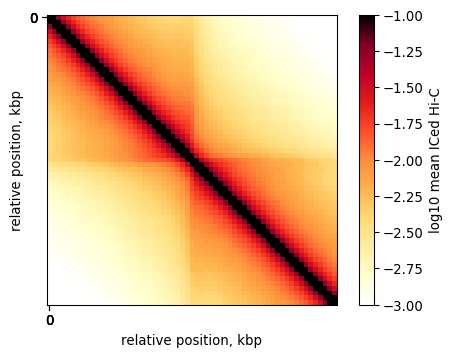

In [18]:
plt.imshow(
    np.log10(pup.loc['all', 'data']),
    vmax = -1,
    vmin = -3.0,
    cmap='fall',
    interpolation='none')

plt.colorbar(label = 'log10 mean ICed Hi-C')
ticks_pixels = np.linspace(0, flank*2//resolution,5)
ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*resolution//1000).astype(int)
plt.xticks(ticks_pixels, ticks_kbp)
plt.yticks(ticks_pixels, ticks_kbp)
plt.xlabel('relative position, kbp')
plt.ylabel('relative position, kbp')

plt.show()

## By-strand pileups

Now, we know that orientation of the CTCF site is very important for the itneractions it forms. Using coolpuppy, splitting regions by the strand is trivial, expecially using a convenience function:

In [19]:
cc = coolpup.CoordCreator(sites, resolution=resolution, features_format='bed', local=True, flank=300_000)
pu = coolpup.PileUpper(clr, cc, view_df=hg38_arms, ignore_diags=0)
pup = pu.pileupsByStrandWithControl()

INFO:root:('chr2_p', 'chr2_p'): 144
INFO:root:('chr2_q', 'chr2_q'): 202
INFO:root:('chr17_p', 'chr17_p'): 78
INFO:root:('chr17_q', 'chr17_q'): 239
INFO:root:Total number of piled up windows: 663


Note that using the convenience fucntions the group "all" is dropped, and index is reset, so the pileups are ready for plotting using the plotting method provided with coolpuppy

In [20]:
pup

,strand1,strand2,data,n,clr,resolution,flank,rescale_flank,chroms,minshift,...,ooe,control,pad_bins,coverage_norm,rescale,rescale_size,flip_negative_strand,ignore_diags,store_stripes,orientation
0,-,-,"[[1.811630495286572, 0.2975886673808751, 0.053...",326,"<Cooler ""test.mcool::/resolutions/10000"">",10000,300000,None,"['chr2', 'chr17']",100000,...,True,False,30,False,False,99,False,0,False,--
1,+,+,"[[1.8198182332525978, 0.2939448199896965, 0.05...",337,"<Cooler ""test.mcool::/resolutions/10000"">",10000,300000,None,"['chr2', 'chr17']",100000,...,True,False,30,False,False,99,False,0,False,++


Now we can use a convenient seaborn-based function from the `plotpup.py` subpackage to create a grid of heatmaps based on by-row and/or by-column variable mapping. In this case, we just map two orientations of CTCF sites across columns.

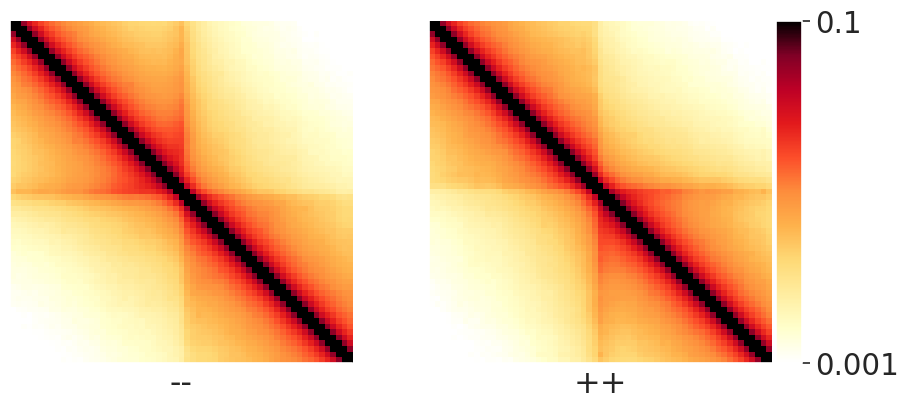

In [21]:
sns.set_theme(font_scale=2)
plotpup.make_heatmap_grid(pup,
                          cols='orientation', col_order=['--', '++'],
                          score=False, cmap='fall', scale='log', sym=False,
                          vmin=0.001, vmax=0.1,
                          height=5)

## Pileups of observed over expected interactions

Sometimes you don't want to include the **distance decay** P(s) in your pileups. For example, when you make comparison of pileups between experiments and they have different P(s). Even if these differences are slight, they might affect the pileup of raw ICed Hi-C interactions. Moreover, without controlling for it the range of values in the pileup is not very easy to guess before plotting.

In this case, the observed over expected pileup is your choice. To normalize your pileup to the background level of interactions, you can either, prior to running the pileup function, calculate expected interactions for each chromosome arms, or you can generate randomly shifted control regions for each snippet, and divide the final pileup by that control pileup.

Let's first try the latter. This analysis is particulalry useful for single-cell Hi-C where the data might be too sparse to generate robust per-diagonal expected values.


In [22]:
cc = coolpup.CoordCreator(sites, resolution=resolution, features_format='bed', local=True, flank=300_000)
pu = coolpup.PileUpper(clr, cc, view_df=hg38_arms, ignore_diags=0,
                       control=True)
pup = pu.pileupsByStrandWithControl()

INFO:root:('chr2_p', 'chr2_p'): 144
INFO:root:('chr2_q', 'chr2_q'): 202
INFO:root:('chr17_p', 'chr17_p'): 78
INFO:root:('chr17_q', 'chr17_q'): 239
INFO:root:Total number of piled up windows: 663


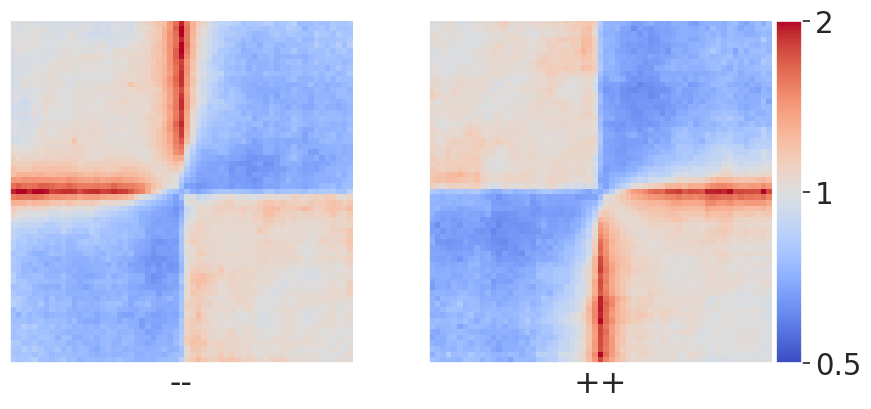

In [23]:
plotpup.make_heatmap_grid(pup,
                         cols='orientation', col_order=['--', '++'],
                         score=False, cmap='coolwarm', scale='log', sym=True,
                         vmax=2,
                         height=5)

As you can see, this strongly highlights the depletion of interactions across the CTCF sites, and enrichment of interactions in a stripe starting from the site.

Now let's calculate per-diagonal expected level of interactions to repeat the analysis using that.

In [24]:
# Calculate expected interactions for chromosome arms
expected = expected_cis(
    clr, 
    view_df=hg38_arms,
    chunksize=1000000)

In [25]:
expected.to_csv('test_expected.tsv', sep='\t', index=False) # Let's save to use it in CLI

In [26]:
pu = coolpup.PileUpper(clr, cc, expected=expected, view_df=hg38_arms, ignore_diags=0, control=False)
pup = pu.pileupsByStrandWithControl()

INFO:root:('chr2_p', 'chr2_p'): 144
INFO:root:('chr2_q', 'chr2_q'): 202
INFO:root:('chr17_p', 'chr17_p'): 78
INFO:root:('chr17_q', 'chr17_q'): 239
INFO:root:Total number of piled up windows: 663


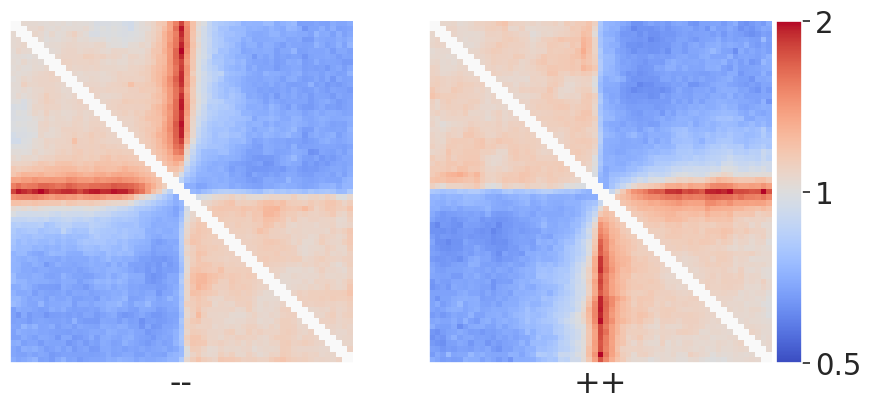

In [27]:
plotpup.make_heatmap_grid(pup,
                          cols='orientation', col_order=['--', '++'],
                          score=False, cmap='coolwarm', scale='log',
                          sym=True, vmax=2,
                          height=5)

The result is almost identical - but note the blank first two diagonals: they are not ignored in the computation, but since they are set to `np.nan` in the expected, so that data is essentially masked.

Instead of splitting two strands into two separate pileups, one can also flip the features on the negative strand. This way a single pileup is created where all features face in the same direction (as if they were on the positive strand).

In [28]:
pu = coolpup.PileUpper(clr, cc, expected=expected, view_df=hg38_arms, flip_negative_strand=True, ignore_diags=0, control=False)
pup = pu.pileupsWithControl()

INFO:root:('chr2_p', 'chr2_p'): 144
INFO:root:('chr2_q', 'chr2_q'): 202
INFO:root:('chr17_p', 'chr17_p'): 78
INFO:root:('chr17_q', 'chr17_q'): 239
INFO:root:Total number of piled up windows: 663


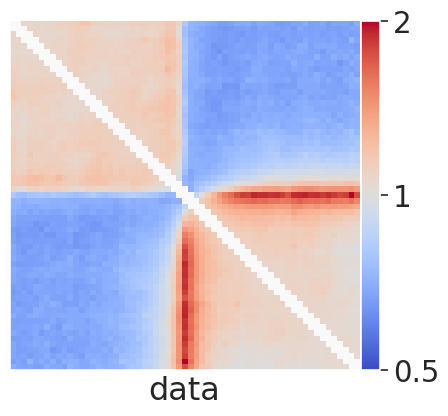

In [29]:
plotpup.make_heatmap_grid(pup,
                          score=False, cmap='coolwarm', scale='log',
                          sym=True, vmax=2,
                          height=5)

## Arbitrary grouping of snippets for pileups

Now, let's see how our selection of only top CTCF peaks affects the results. We could simply repeat the analysis with the rest of CTCF peaks, but to showcase the power of coolpuppy, we'll demonstrate how it can be used to generate pileups split be arbitrary categories

In [30]:
cc = coolpup.CoordCreator(ctcf, resolution=resolution, features_format='bed', local=True, flank=300_000) # Using all sites here
pu = coolpup.PileUpper(clr, cc, expected=expected, flip_negative_strand=True, view_df=hg38_arms, ignore_diags=0)
pup = pu.pileupsWithControl(groupby=['peaks_importance1']) # Splitting all snippets into groups based on annotated previously importance of the peaks
                                                           # using a more generic function without hardcoded grouping. Also flipping negative stranded features
                                                           # as shown above.

INFO:root:('chr2_p', 'chr2_p'): 1381
INFO:root:('chr2_q', 'chr2_q'): 2221
INFO:root:('chr17_p', 'chr17_p'): 548
INFO:root:('chr17_q', 'chr17_q'): 1602
INFO:root:Total number of piled up windows: 5752


In [31]:
pup # Remember that the output looks a bit different from the convenience function used above:
    # group annotation is stored in the index, and there is a group 'all' which stores all data

,data,n,clr,resolution,flank,rescale_flank,chroms,minshift,maxshift,nshifts,...,expected_value_col,ooe,control,pad_bins,coverage_norm,rescale,rescale_size,flip_negative_strand,ignore_diags,store_stripes
peaks_importance1,,,,,,,,,,,,,,,,,,,,,
Ordinary peaks,"[[nan, nan, 1.0616930019956201, 1.061335326717...",3536,"<Cooler ""test.mcool::/resolutions/10000"">",10000,300000,None,"['chr2', 'chr17']",100000,1000000,10,...,balanced.avg,True,False,30,False,False,99,True,0,False
Top by FC score,"[[nan, nan, 1.0870400730009782, 1.085674181483...",778,"<Cooler ""test.mcool::/resolutions/10000"">",10000,300000,None,"['chr2', 'chr17']",100000,1000000,10,...,balanced.avg,True,False,30,False,False,99,True,0,False
Top by Motif score,"[[nan, nan, 1.0250216843301423, 1.031031719773...",775,"<Cooler ""test.mcool::/resolutions/10000"">",10000,300000,None,"['chr2', 'chr17']",100000,1000000,10,...,balanced.avg,True,False,30,False,False,99,True,0,False
Top by both scores,"[[nan, nan, 1.0823560747328584, 1.066658050473...",663,"<Cooler ""test.mcool::/resolutions/10000"">",10000,300000,None,"['chr2', 'chr17']",100000,1000000,10,...,balanced.avg,True,False,30,False,False,99,True,0,False
all,"[[nan, nan, 1.0626097303152733, 1.061234341409...",5752,"<Cooler ""test.mcool::/resolutions/10000"">",10000,300000,None,"['chr2', 'chr17']",100000,1000000,10,...,balanced.avg,True,False,30,False,False,99,True,0,False


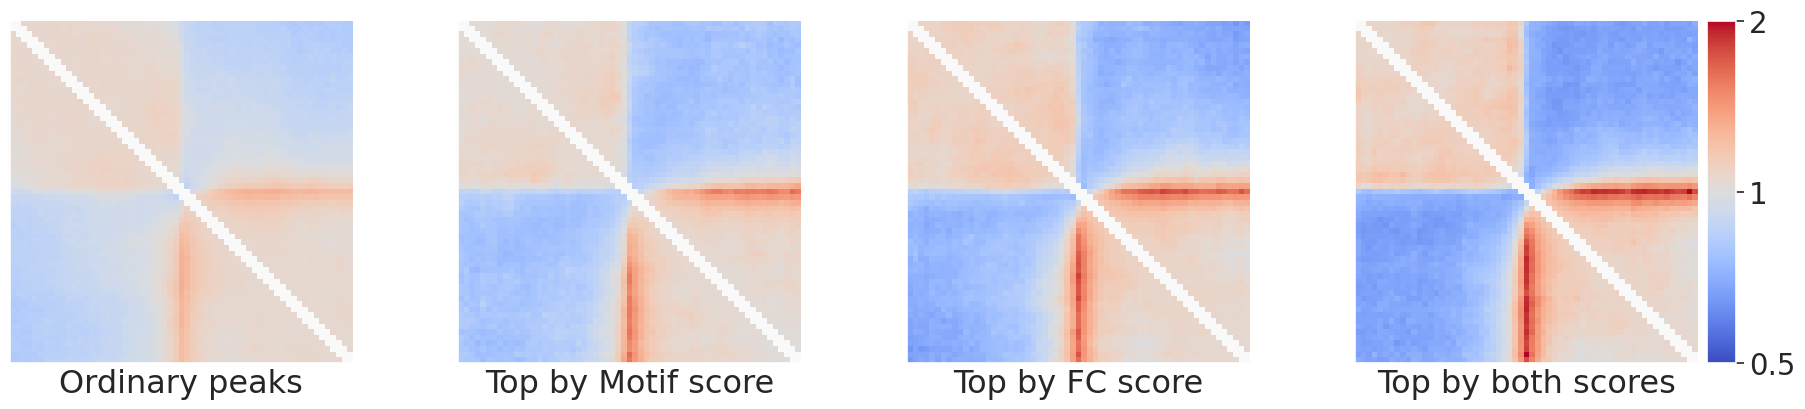

In [32]:
fg = plotpup.make_heatmap_grid(pup.reset_index(), # Simply resetting the idnex makes the output directly compatible with the plotting function - 
                                                        # just need to remember there is also a group "all" which you might not want to show
                               cols='peaks_importance1',
                               col_order=['Ordinary peaks', 'Top by Motif score',
                                          'Top by FC score', 'Top by both scores'],
                               score=False, cmap='coolwarm',
                               scale='log', sym=True, vmax=2,
                               height=5)

## By-distance pileups

As it is known, CTCF sites frequently have peaks of Hi-C interactions between them, that indicate chromatin loops. Let's see at what distances they tend to occur, and let's see what patterns these regions form at different distance separations and different motif orientations.

Since we generate many more snippets than for local (on-diagonal) pileups, it will take a little longer to run. We can use the `nproc` argument to use multiprocessing and run it in parallel to speed it up a bit. Note that parallelization requires more RAM, so use with caution.

In [33]:
cc = coolpup.CoordCreator(sites, resolution=resolution, features_format='bed', flank=300_000, mindist=100000)
# Using all strong sites here to make it faster
pu = coolpup.PileUpper(clr, cc, expected=expected, view_df=hg38_arms, ignore_diags=0)
pup = pu.pileupsByStrandByDistanceWithControl(nproc=2)
# Splitting all snippets into groups based on strand and separation between two sites

INFO:root:('chr2_p', 'chr2_p'): 10250
INFO:root:('chr17_p', 'chr17_p'): 2959
INFO:root:('chr2_q', 'chr2_q'): 20215
INFO:root:('chr17_q', 'chr17_q'): 28284
/gpfs/igmmfs01/eddie/wendy-lab/elias/coolpuppy_trans/coolpuppy/coolpuppy/coolpup.py:1913: PerformanceWarning: indexing past lexsort depth may impact performance.
  n = normalized_roi.loc["all", "n"]
INFO:root:Total number of piled up windows: 61708
/gpfs/igmmfs01/eddie/wendy-lab/elias/coolpuppy_trans/coolpuppy/coolpuppy/coolpup.py:2047: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  normalized_pileups = normalized_pileups.drop(index="all").reset_index()


In [34]:
pup

,strand1,strand2,distance_band,data,n,clr,resolution,flank,rescale_flank,chroms,...,control,pad_bins,coverage_norm,rescale,rescale_size,flip_negative_strand,ignore_diags,store_stripes,orientation,separation
0,-,-,"(200000, 400000)","[[1.1228430483549134, 1.099652109478817, 1.116...",116,"<Cooler ""test.mcool::/resolutions/10000"">",10000,300000,None,"['chr2', 'chr17']",...,False,30,False,False,99,False,0,False,--,0.2Mb-\n0.4Mb
1,-,-,"(800000, 1600000)","[[0.5976636400929767, 0.5492131020921298, 0.58...",454,"<Cooler ""test.mcool::/resolutions/10000"">",10000,300000,None,"['chr2', 'chr17']",...,False,30,False,False,99,False,0,False,--,0.8Mb-\n1.6Mb
2,-,-,"(100000, 200000)","[[1.170114529584341, 1.1042241914500734, 1.178...",61,"<Cooler ""test.mcool::/resolutions/10000"">",10000,300000,None,"['chr2', 'chr17']",...,False,30,False,False,99,False,0,False,--,0.1Mb-\n0.2Mb
3,-,-,"(1600000, 3200000)","[[0.720351536520605, 0.732722859986511, 0.7264...",723,"<Cooler ""test.mcool::/resolutions/10000"">",10000,300000,None,"['chr2', 'chr17']",...,False,30,False,False,99,False,0,False,--,1.6Mb-\n3.2Mb
4,-,+,"(400000, 800000)","[[0.7311102559568206, 0.7334596659234779, 0.69...",245,"<Cooler ""test.mcool::/resolutions/10000"">",10000,300000,None,"['chr2', 'chr17']",...,False,30,False,False,99,False,0,False,-+,0.4Mb-\n0.8Mb
5,+,-,"(800000, 1600000)","[[0.5733927265191414, 0.6287673343701548, 0.62...",423,"<Cooler ""test.mcool::/resolutions/10000"">",10000,300000,None,"['chr2', 'chr17']",...,False,30,False,False,99,False,0,False,+-,0.8Mb-\n1.6Mb
6,-,-,"(400000, 800000)","[[0.6041652783315788, 0.6410074087801781, 0.69...",257,"<Cooler ""test.mcool::/resolutions/10000"">",10000,300000,None,"['chr2', 'chr17']",...,False,30,False,False,99,False,0,False,--,0.4Mb-\n0.8Mb
7,+,+,"(400000, 800000)","[[0.6771101638781061, 0.6750807544701738, 0.67...",245,"<Cooler ""test.mcool::/resolutions/10000"">",10000,300000,None,"['chr2', 'chr17']",...,False,30,False,False,99,False,0,False,++,0.4Mb-\n0.8Mb
8,+,+,"(200000, 400000)","[[0.8419593686311506, 0.8244833974173467, 0.83...",131,"<Cooler ""test.mcool::/resolutions/10000"">",10000,300000,None,"['chr2', 'chr17']",...,False,30,False,False,99,False,0,False,++,0.2Mb-\n0.4Mb
9,+,-,"(200000, 400000)","[[0.9557850731643714, 0.9513478530013351, 0.85...",131,"<Cooler ""test.mcool::/resolutions/10000"">",10000,300000,None,"['chr2', 'chr17']",...,False,30,False,False,99,False,0,False,+-,0.2Mb-\n0.4Mb


In [35]:
# Note that in this case the longest distance band doesn't contain any useful data, so we can just remove it
pup = pup[pup['distance_band']!=(102400000, 204800000)]

In [36]:
# Now let's add cnovenient and shorter names for the distance bands for plotting
pup['separation'] = pup['distance_band'].apply(lambda x: f'{x[0]/1000000}Mb-\n{x[1]/1000000}Mb')

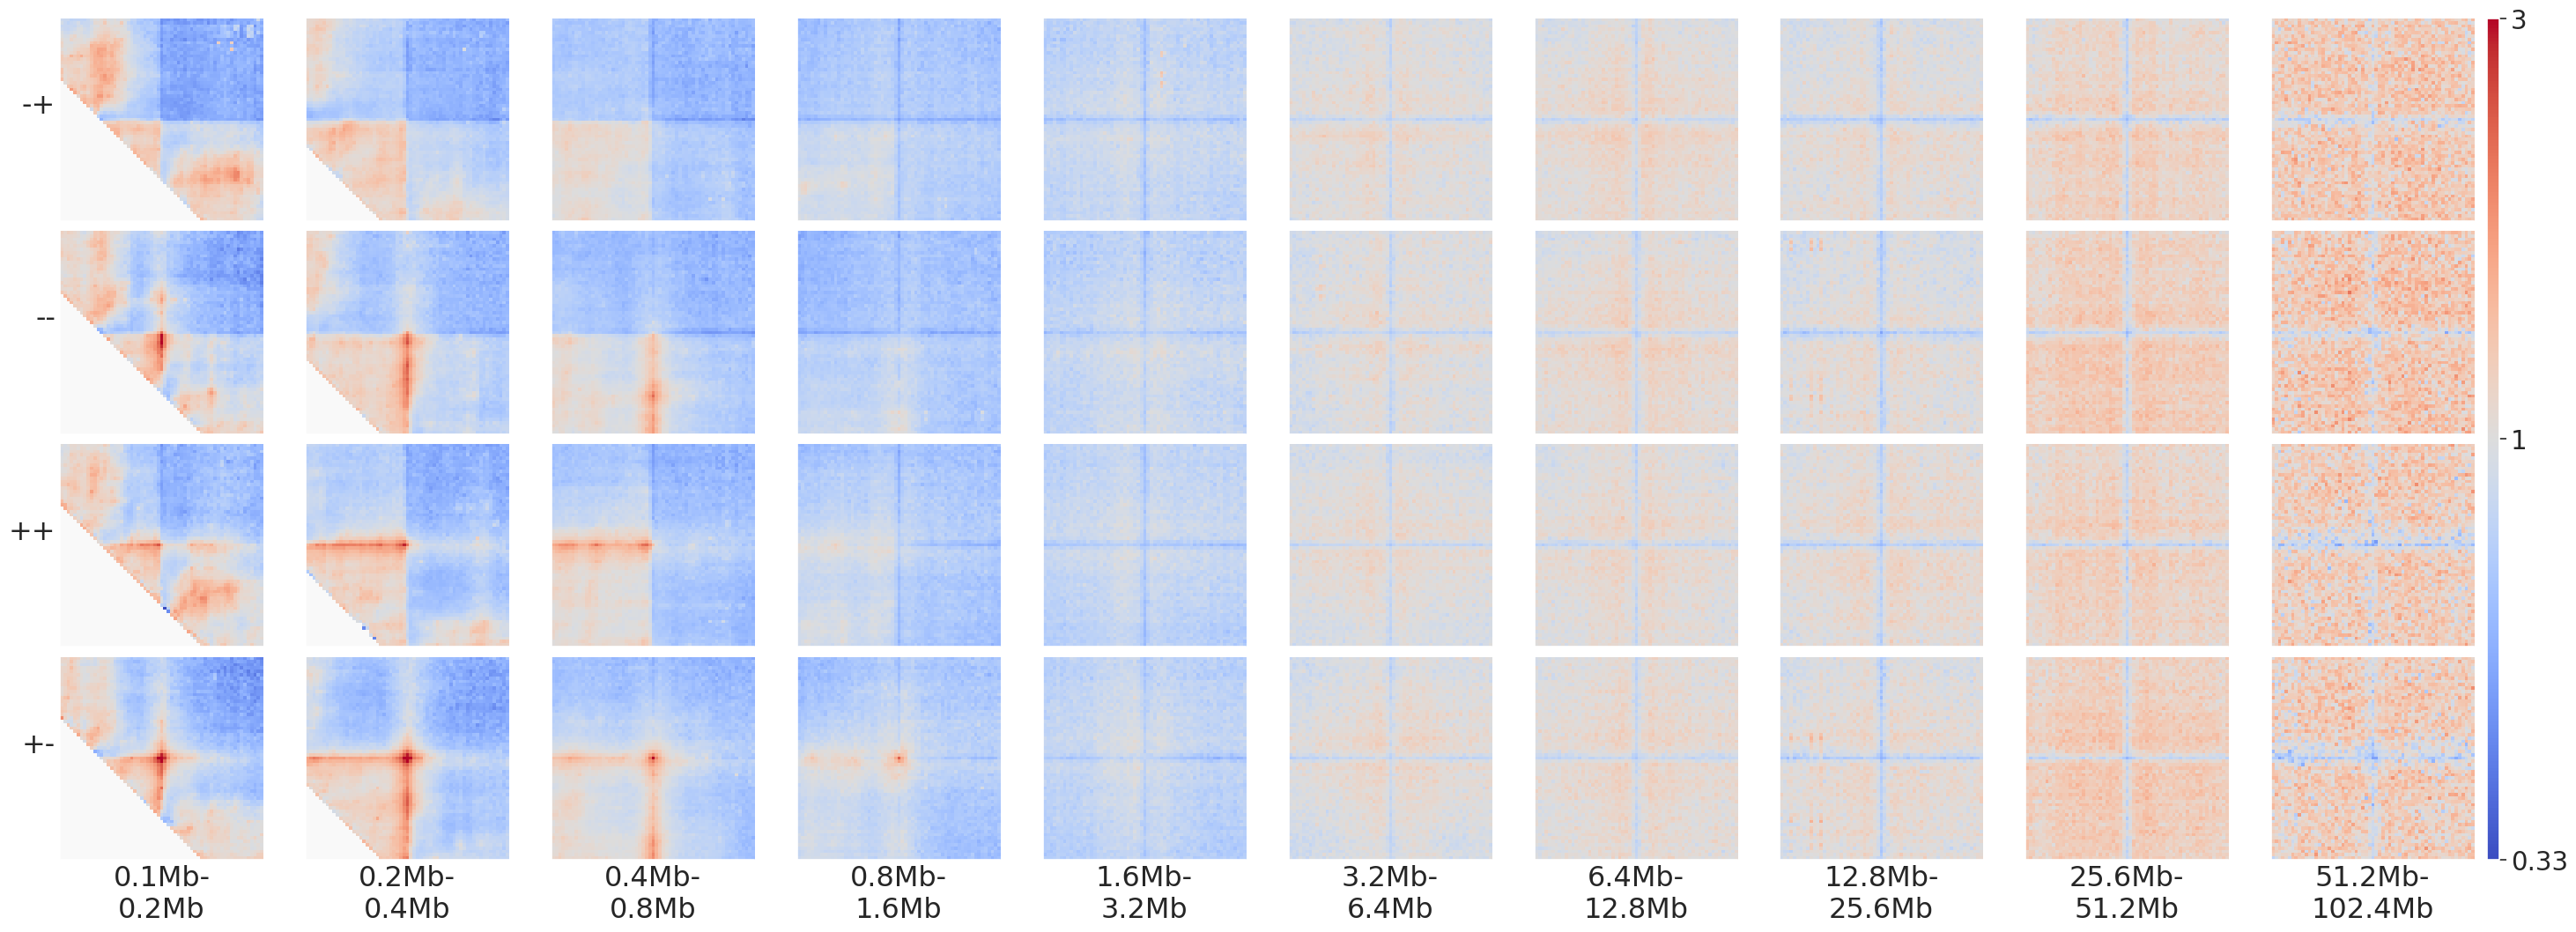

In [37]:
fg = plotpup.make_heatmap_grid(pup, rows='orientation', cols='separation',
                               row_order=['-+', '--', '++', '+-'],
                               col_order=sorted(set(pup['separation']), key=lambda x:float(x.split('Mb')[0])),
                               score=False, cmap='coolwarm', scale='log', sym=True, vmax=3,
                               height=3)

Note that since CTCF sites are preferentially found in the A compartment, the expected level of interactions at different distances varies, generating different background interaction levels. We can artificially fix that by normalizing each pileup by the average interactions in the top-left and bottom-right corners.

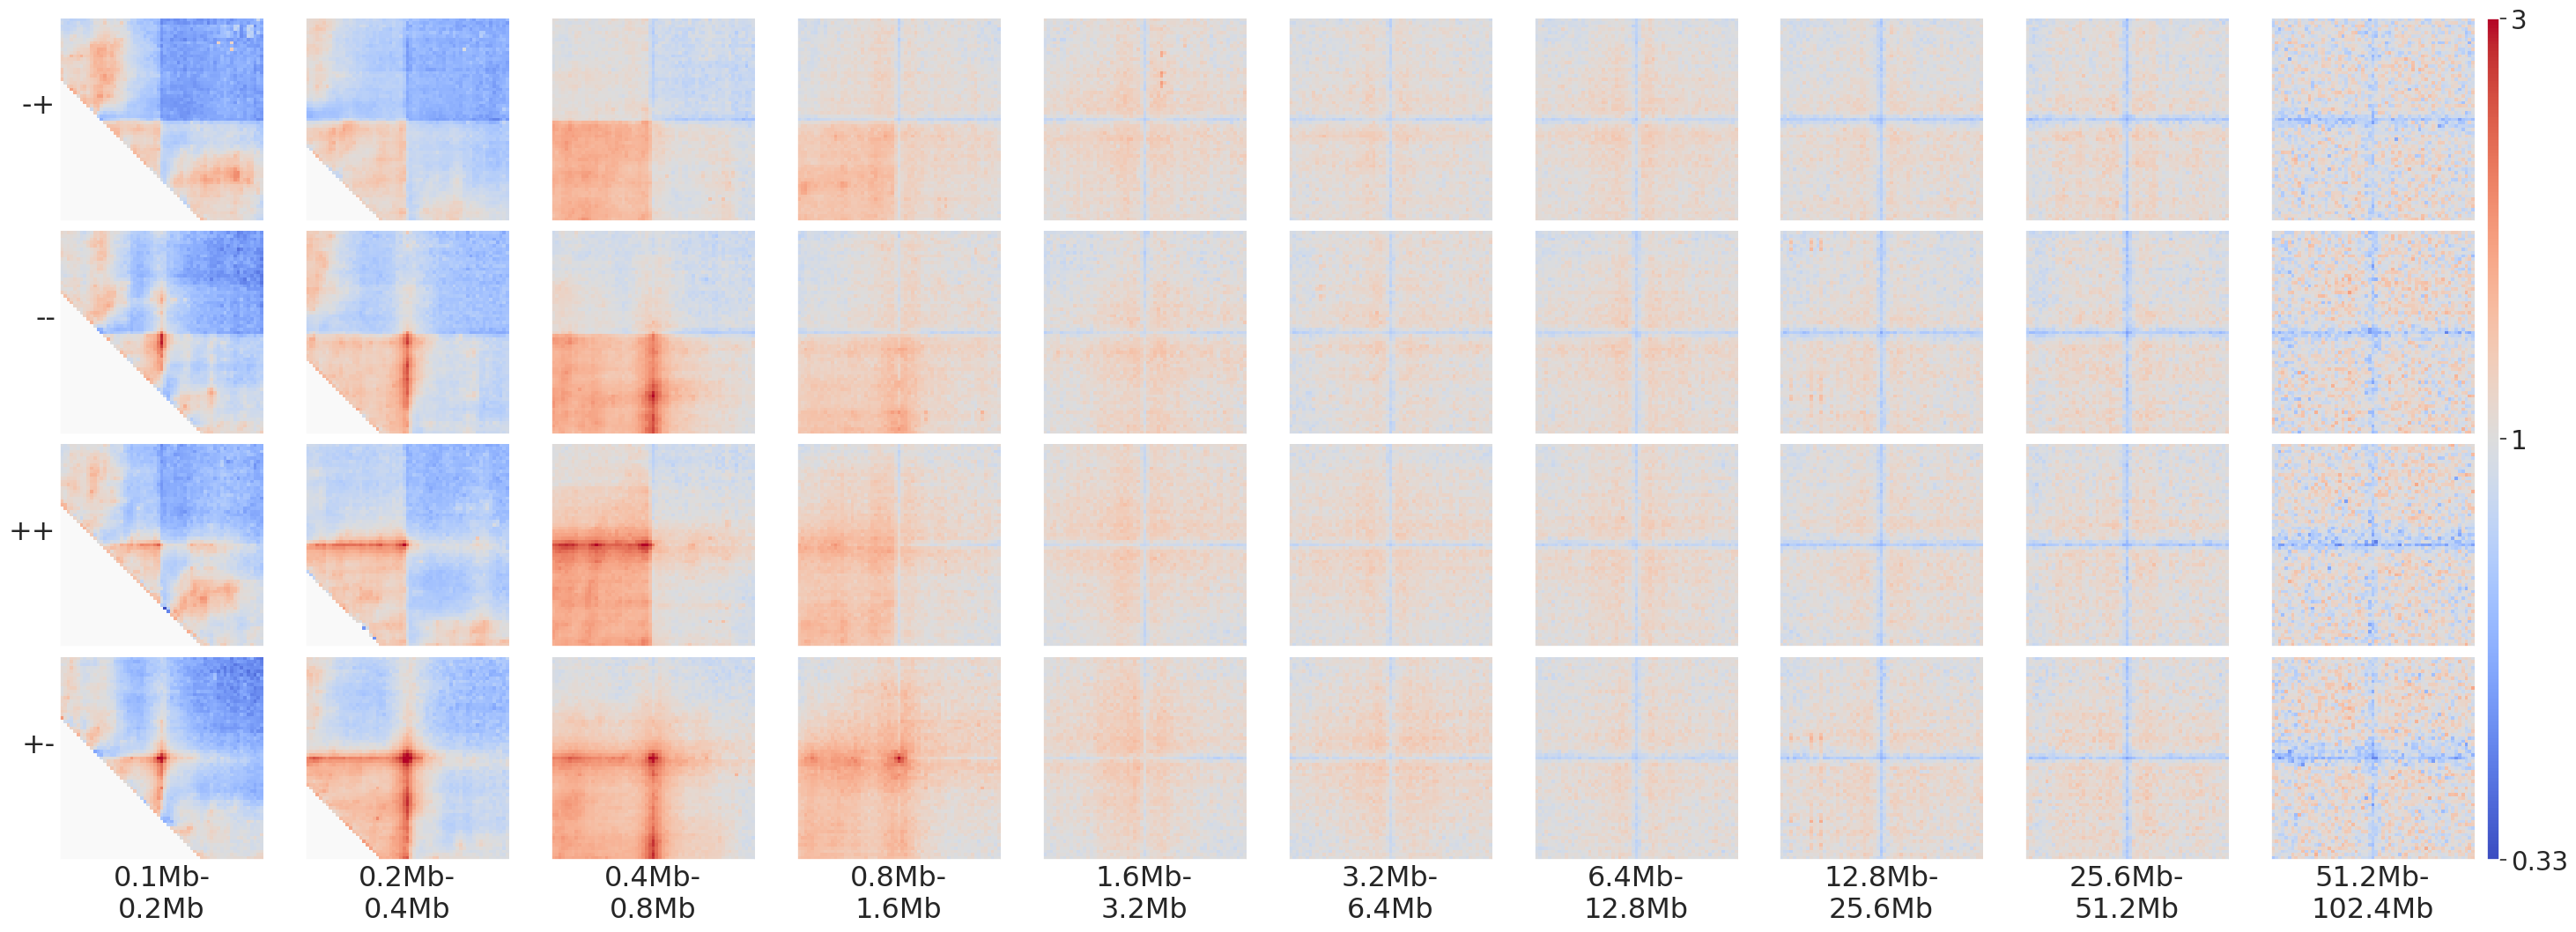

In [38]:
fg = plotpup.make_heatmap_grid(pup, rows='orientation', cols='separation',
                               row_order=['-+', '--', '++', '+-'],
                               col_order=sorted(set(pup['separation']), key=lambda x:float(x.split('Mb')[0])),
                               score=False, cmap='coolwarm', scale='log', sym=True, vmax=3,
                               norm_corners=10,
                               height=3)

If you want to actually modify the data in your dataframe to normalize to the corners and not just apply it for vizualisation, you can do that explicitly:

In [39]:
pup['data'] = pup['data'].apply(coolpup.norm_cis, i=10)

A good idea to give some more quantitative information about the level of enrichment of interactions in the center of the pileup is to just label the average value of the few central pixels of the heatmap. Simples way is to add a column that contains this score to the dataframe, and then provide its name to the `make_heatmap_grid` function argument `score`:

In [40]:
pup['score'] = pup['data'].apply(coolpup.get_enrichment, n=3) # Use the central 3x3 square to get
                                                               # average interaction strength

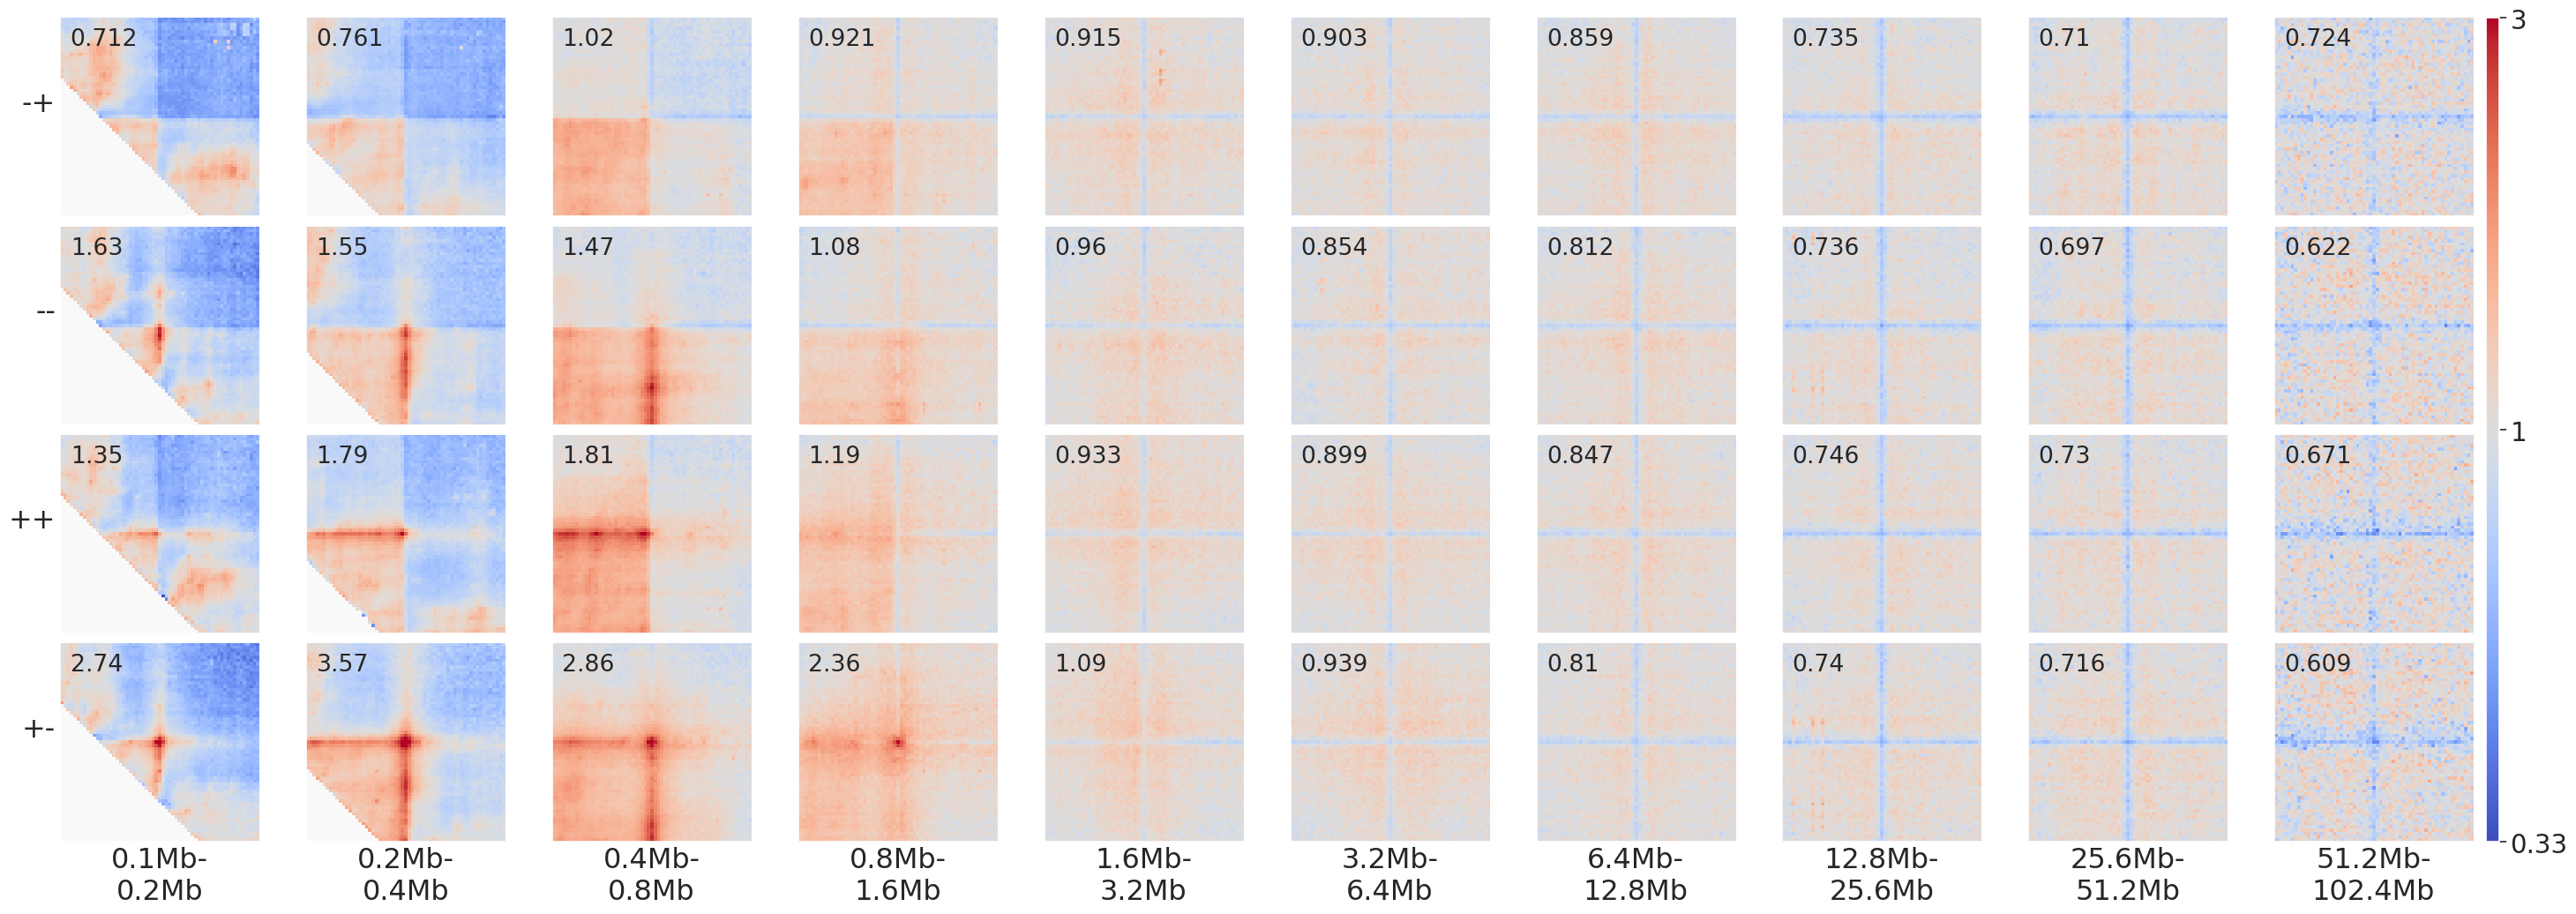

In [41]:
fg = plotpup.make_heatmap_grid(pup, rows='orientation', cols='separation',
                               row_order=['-+', '--', '++', '+-'],
                               col_order=sorted(set(pup['separation']), key=lambda x:float(x.split('Mb')[0])),
                               score='score',
                               cmap='coolwarm', scale='log', sym=True, vmax=3,
                               height=3)